# SK Part 7: Neural Networks
## A Simple Case Study

### Background

Neural Networks (NNs) (nowadays also known as deep learning (DL)) are at the heart of modern machine learning. They have been used successfully at solving some of the most challenging machine learning problems in the world including image and video recognition, speech recognition, and generative adversarial network problems. Despite their superior performance, NNs have several drawbacks:
- They usually require a lot of data to perform well.
- They are black box models and their results are almost impossible to explain.
- The math behind NNs is complicated and not easy to grasp for many people.
- For the "wrong" type of problem, they can overfit like crazy.
- Training NNs can become mathematically challenging due to this so-called vanishing gradient phenomena.
- NNs have a huge number of hyperparameters to fine tune.
- Fine tuning NNs is notoriously difficult and challenging and it can make your life miserable (seriously).

On the other hand, NNs can be the preferred tool in the following cases:
- You have lots of data.
- You data contains little nuances that is hard to be recognized by the more conventional ML methods.
- You have lots of numerical features.
- Your target feature is numeric (though NNs also work well for classification problems).

Thus, NNs can be considered as specialized tools for specific purposes. For some of problems in the real-world that do not involve image/ video/ speech recognition, you might be better off by staying away from them. On the other hand, you should never underestimate the power of a carefully fine-tuned NN. So, it really depends.

### Objectives

The objective of this notebook is to model the `US Census Income Data` case study, which is a binary classification problem, using neural networks. Even though it can be challenging to grasp how NNs work, **you do not really need to know in full details how things work behind the scenes**. Instead, you can stick to good practices for tuning them and have a look at its cross-validated performance.

We need to warn you that this notebook barely scratches the surface of NN/ DLs and it will be very brief. Its purpose is to give you a headstart in case you would like to experiment with NN/ DLs sometime in your career in the future.

### Packages

You will need to install `tensorflow` (Google's deep learning software library) and its `keras` interface as shown below. These two are by far the two most popular DL tools out there at the moment.

```Python
pip install tensorflow
pip install keras
```

The good news is, even though NNs are hard to work with in general, `tensorflow` and `keras` together make this process as simple as it can possibly be.

### Task 0: Modeling Preparation

- Read in the clean data from GitHub, which is named as `us_census_income_data_clean.csv`. 
- Randomly sample 20000 rows using a random seed of 999.
- You will split the sampled data as 70% training set and the remaining 30% **validation** (not test!) set using a random seed of 999. However, you will use the name "test" for naming variables to be consistent with the previous tutorials.
- Remember to separate `target` during the splitting process. 

In [1]:
import numpy as np
import pandas as pd

# so that we can see all the columns
pd.set_option('display.max_columns', None) 

# setup matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests

# so that we can see all the columns
pd.set_option('display.max_columns', None) 

# for Mac OS users only!
# if you run into any SSL certification issues, 
# you may need to run the following command for a Mac OS installation.
# $/Applications/Python 3.x/Install Certificates.command
# if this does not fix the issue, please run the code chunk below
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

data_url = 'https://raw.githubusercontent.com/vaksakalli/datasets/master/us_census_income_data_clean_encoded.csv'
url_content = requests.get(data_url).content
df = pd.read_csv(io.StringIO(url_content.decode('utf-8')))

df.shape

(45222, 42)

In [3]:
num_samples = 20000

df = df.sample(n=num_samples, random_state=999)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Data = df.drop(columns=['target'])

target = df['target'].values.reshape(-1, 1) 

# scale all columns in X to be between 0 and 1 in case they are not
scaler_Data = MinMaxScaler().fit(Data.values)
Data_scaled = scaler_Data.transform(Data.values)

# you should ALWAYS normalize target as well for neural networks
# but for this problem, target is already between 0 and 1 (since it's binary)

In [5]:
D_train, D_test, t_train, t_test, idx_train, idx_test = \
   train_test_split(Data_scaled, target, Data.index, test_size=0.3, random_state=999)

### Task 1: Defining Network Parameters

As mentioned earlier, fine tuning NNs is notoriously difficult due to the large number of parameters. For this example, you will use a NN with two hidden layers. This is referred to as the `topology` of the NN. Here is an illustration of a neural network with 3 input features and two hidden layers with 4 neurons in each hidden layer (source: medium.com).

<img src=https://miro.medium.com/max/1000/1*3fA77_mLNiJTSgZFhYnU0Q.png width="600">

In addition to the hidden layers, you will need to have two more layers:
- an input layer (which are the scaled descriptive features) and 
- an output layer (which is the target feature, i.e., the prediction of the network). 

Neurons in the hidden layers are nonlinear functions (in general). Via these functions (called activation functions), you are  approximating the output as a highly nonlinear function of the input features. The higher the number of neurons and/ or number of hidden layers, the higher the nonlinearity of the relationship between the input features and the target feature.

The size of the network is determined by the number of neurons in each layer. You might want to start small and then make the network bigger until performance stops increasing. As a general guideline, your network should be as small as possible to prevent overfitting on unseen observations. Another practice is that number or neurons in the second layer should not be higher than the first layer.

For the hidden layers, in addition to how many neurons you want in each layer, you also need to specify which type of activation function you will use for each of them. For the hidden layers, `relu` is a popular choice, which is short for `rectified linear unit`. You can learn more about these activation functions [here](https://keras.io/activations/). 

After each hidden layer, you might want to add a `dropout` layer, which has been shown to reduce the chances of overfitting in some cases. For these dropout layers, you will need to specify the dropout rate. However, do not automatically assume dropout is the ultimate solution. Sometimes regularization in the layers might be a better idea; see Keras documentation [here](https://keras.io/regularizers/) for more information.

For the output layer, if your problem is binary classification, you will need to use a sigmoid activation function whose output is always between 0 and 1.

For the training process, you will need to specify 
- The number of epochs (that is, training iterations): You will look for an elbow-shaped performance curve to determine the number of epochs. Too big values for this parameter would result in overfitting and too small values in underfitting. So this is a critical parameter to achieve a good balance between over and under fitting.
- Batch size (size of data chunk to feed into NN one at a time)

For training the network, you will need to specify
- The optimization algorithm and its parameters (more info [here](https://keras.io/optimizers/))
- Loss function (more info [here](https://keras.io/losses/))
- Metrics to monitor during the training (more info [here](https://keras.io/api/metrics/))

For this exercise task, you will set the above parameters to specific values. **In practice, all these values need to be tuned!!!** On the other hand, there is a huge level of interaction between these parameters. Besides, the NN performance can be very sensitive to even small changes in one of the parameters. **That's what makes NN tuning so tedious and difficult.** For instance, the batch size, which might perhaps appear trivial initially, can be absolutely critical in obtaining a satisfactory performance. 

In [6]:
# size of the network is determined by the number of neural units in each hidden layer
layer1_units = 4
layer2_units = 4

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.optimizers import SGD

In [8]:
loss = 'binary_crossentropy' 
# during training, we would like to monitor accuracy
metrics = ['accuracy'] 

In [9]:
epochs = 500
batch_size = 100

In [10]:
layer1_activation = 'relu'
layer2_activation = 'relu'
output_activation = 'sigmoid'

In [11]:
layer1_dropout_rate = 0.05
layer2_dropout_rate = 0.00

In [12]:
learning_rate=0.01
decay=1e-6
momentum=0.5
# SGD stands for stochastic gradient descent
optimizer = SGD(lr=learning_rate, decay=decay, momentum=momentum)

### Task 2: Setting up the Model

The code chunk below sets up the NN model based on the specified input parameters.

In [13]:
# set up an empty deep learning model
def model_factory(input_dim, layer1_units, layer2_units):
    model = Sequential()
    model.add(Dense(layer1_units, input_dim=input_dim, activation=layer1_activation))
    model.add(Dropout(layer1_dropout_rate))
    model.add(Dense(layer2_units, activation=layer1_activation))
    model.add(Dropout(layer2_dropout_rate))
    model.add(Dense(1, activation=output_activation))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

### Task 3: Utility Function for Plotting

You will define a function to plot performance of the NN during training. You will plot the performance on both the training data and the validation data.

In [14]:
# define plot function for the fit
# we will plot the accuracy here
def plot_history(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

### Task 4: Model Training

You are now ready to train your model. If you want to see results at the end of each iteration, set `verbose` to 1. Otherwise keep it at 0 for no details. Keep in mind that, especially for a large number of epochs, **the fitting process can take a lot of time.**

In [15]:
model_test = model_factory(Data.shape[1], layer1_units, layer2_units)

# in the summary, notice the LARGE number of total parameters in the model
model_test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 168       
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [16]:
%%time
history_test = model_test.fit(D_train, 
                              t_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0, # set to 1 for iteration details, 0 for no details
                              shuffle=True,
                              validation_data=(D_test, t_test))

Wall time: 53.7 s


In [17]:
# here are the keys in the history attribute of the fitted model object
history_test.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Task 5: Plotting Results

You will plot the results using our utility plotting function we defined earlier.

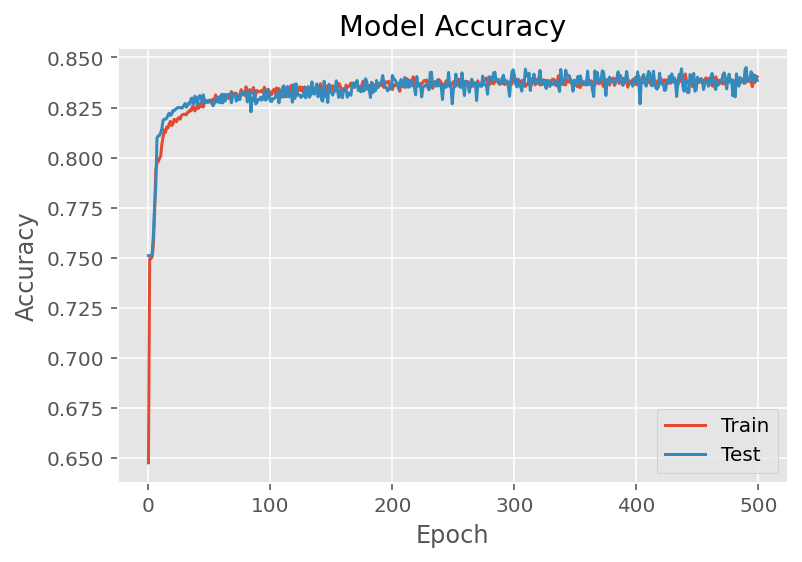

In [18]:
plot_history(history_test)

### Task 6: Performance Evaluation

You will get the predictions on the validation data and have a look at accuracy and AUC on the validation data. As an exercise, compare the accuracy here to the test accuracy you obtained for the same problem in the SK0 practice notebook. 

In [19]:
# compute prediction performance on test data
model_output = model_test.predict(D_test).astype(float)

# decide classification based on threshold of 0.5
t_pred = np.where(model_output < 0.5, 0, 1)

# set up the results data frame
result_test = pd.DataFrame()
result_test['target'] = t_test.flatten()
result_test['fit'] = t_pred
# residuals will be relevant for regression problems
# result_test['abs_residual'] = np.abs(result_test['target'] - result_test['fit'])
result_test.head()

,target,fit
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0


In [20]:
acc = accuracy_score(result_test['target'], result_test['fit'])
auc = roc_auc_score(result_test['target'], result_test['fit'])
print(f"validation data accuracy_score = {acc:.3f}")
print(f"validation data roc_auc_score = {auc:.3f}")

validation data accuracy_score = 0.839
validation data roc_auc_score = 0.730


### Task 7: Next Steps

As an exercise, do the following:
- First increase the number of samples, perhaps use **all** the data. The reason NNs work well when they do is because they can pick up the small nuances in the data.
- Next, play around with the network parameters to see if you can improve the performance.

***
www.featureranking.com